In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.autograd import Variable

from itertools import product

from collections import namedtuple
from collections import OrderedDict

from IPython.display import display, clear_output

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Helper Functions

## Squashing Function

In [ ]:
# implement class wrapper for squashing activation function
class SquashingFunction(nn.Module):
    '''
    Shape:
        - Input: (N, *) where * means, any number of additional dimensions
        - Output: (N, *), same shape as the input
    Examples:
        m = squashing(beta=25)
        input = torch.randn(2)
        output = m(input)

        Input/Output have same shape:
        input.shape
        output.shape
    '''
    def __init__(self, beta=0.1):
        '''
        Init method.
        '''
        super(SquashingFunction, self).__init__()
        
        self.alpha = 0.5
        self.lam = 1.0
        
        self.beta = Parameter(torch.tensor(beta))   # create a tensor out of beta
        self.beta.requiresGrad = True               # set requiresGrad to true!

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        global betas 
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )

## Gaussian Distribution Data

In [ ]:
def classifyGaussianData(num_samples):
    """ getting a specific number of gauss data points i.e. simple linear data"""
    points = []
    radius = 6
    
    #Points 1
    for i in range(0, num_samples//2):
        x = np.random.normal(-radius/2, 1)
        y = np.random.normal(-radius/2, 1)
        if(x+y >= 0):
            points.append([x, y, 0])
        else:
            points.append([x, y, 1])

            
    # Points 2
    for i in range(0, num_samples//2):
        x = np.random.normal(radius/2, 1)
        y = np.random.normal(radius/2, 1)
        if(x+y >= 0):
            points.append([x, y, 0])
        else:
            points.append([x, y, 1])

    
    points = np.asarray(points, dtype=np.float32)
    points = np.random.permutation(points)
    return points

## Network Implementation

In [ ]:
class GaussianDataNet(nn.Module):
    def __init__(self):
        super(GaussianDataNet, self).__init__()

        self.out = nn.Linear(in_features=2, out_features=2)
        self.activation = SquashingFunction()
        
    #This must be implemented
    def forward(self, x):
        x=self.out(x)
        x=self.activation(x)
        return x

## Run Builder

In [ ]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [ ]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
    def __init__(self):

        # tracking every epoch count, loss, accuracy, time
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        # tracking every run count, run data, hyper-params used, time
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        # record model, loader and TensorBoard 
        self.network = None
        self.accuracy = 0
        train_accuracy = 0
        test_accuracy = 0

    # record the count, hyper-param, model, loader of each run
    # record sample images and network graph to TensorBoard  
    def begin_run(self, run, network):

        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1

        self.network = network

    # when run ends, close TensorBoard, zero epoch count
    def end_run(self):
        self.epoch_count = 0


    # zero epoch count, loss, accuracy, 
    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0


    # 
    def end_epoch(self):
        # calculate epoch duration and run duration(accumulate)
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        # record epoch loss and accuracy
        #accuracy = accuracy_score(model.predict(X),y)
        
        # train accuracy
        predict_out = net(train_X)
        _, predict_y = torch.max(predict_out, 1)
        train_accuracy = accuracy_score(train_y.data, predict_y.data)
        
        # test accuracy
        predict_out = net(test_X)
        _, predict_y = torch.max(predict_out, 1)
        test_accuracy = accuracy_score(test_y.data, predict_y.data)
    
        # Write into 'results' (OrderedDict) for all run related data
        results = OrderedDict()
        
        results["betas"] = betas
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = self.epoch_loss
        results["train_accuracy"] = train_accuracy
        results["test_accuracy"] = test_accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        
        # Record hyper-params into 'results'
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

        # display epoch information and show progress
        if results["epoch"] % 100 == 0:
            clear_output(wait=True)
            display(df)


    # accumulate loss of batch into entire epoch loss
    def track_loss(self, loss):
        # multiply batch size so variety of batch sizes can be compared
        self.epoch_loss += loss.item()


    # accumulate number of corrects of batch into entire epoch num_correct
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)


    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    

    # save end results of all runs into csv, json for further analysis
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data, 
            orient = 'columns',
        ).to_csv(f'{fileName}.csv')

# Generate Data Points

In [ ]:
data = classifyGaussianData(num_samples=500)
X, y = data[:, :2], data[:, 2]

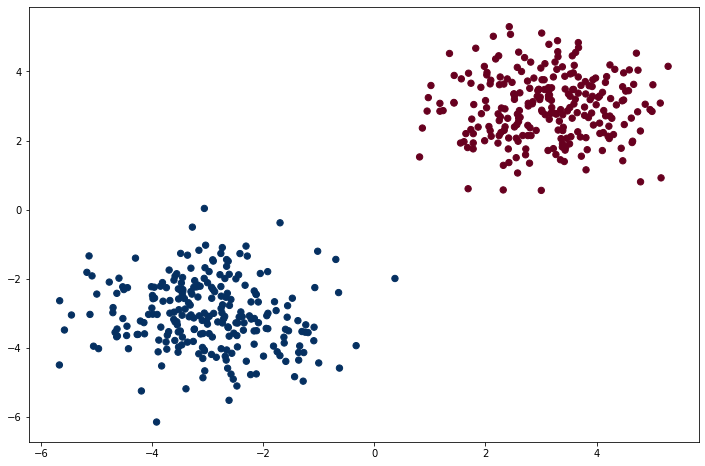

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.RdBu)

# Training

In [ ]:
params = OrderedDict(
    lr = [.1],
    epochs = [10]
)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.1)

In [ ]:
train_X = Variable(torch.Tensor(train_X).float())
test_X = Variable(torch.Tensor(test_X).float())
train_y = Variable(torch.Tensor(train_y).long())
test_y = Variable(torch.Tensor(test_y).long())

## Training Loop

In [ ]:
m = RunManager()

In [ ]:
# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):
    # Initialize the model    
    net = GaussianDataNet()
    
    # Define loss criterion
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=run.lr)
    
    losses=[]
    m.begin_run(run, net)
    contour_plot_array = []   
    for epoch in range(run.epochs+1):
        m.begin_epoch()
        # Clear the previous gradients
        optimizer.zero_grad()
        out = net(train_X)
        # Compute Cross entropy loss
        loss = criterion(out, train_y)
        # Add loss to the list
        losses.append(loss.item())
        # Compute gradients
        loss.backward()
        # Adjust weights
        optimizer.step()
        
        m.track_loss(loss)
        m.end_epoch()

        if epoch in [0, 3, 4, 5, 8, 10]:
            i = np.linspace(-7, 7, 50)
            j = np.linspace(-7, 7, 40)
            mesh = np.meshgrid(i, j)
            a=np.zeros((2000,2))
            a[:,0]=np.ravel(mesh[0])
            a[:,1]=np.ravel(mesh[1])
            contour_test=torch.Tensor(a)
            predict_out = net(contour_test)
            contour_plot = predict_out.detach().numpy()[:,1]
            contour_plot.shape
            contour_plot_array.append(contour_plot)
    m.end_run()

## Plots

[]

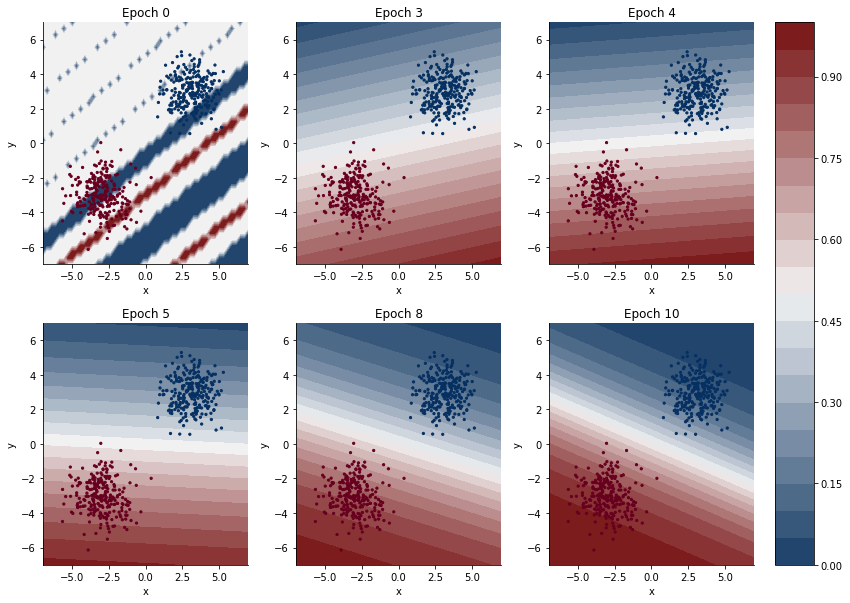

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(11.69, 8.27))

i = np.linspace(-7, 7, 50)
j = np.linspace(-7, 7, 40)
mesh = np.meshgrid(i, j)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)

# Labels
axs[0, 0].set(xlabel='x', ylabel='y', title='Epoch 0');
axs[0, 1].set(xlabel='x', ylabel='y', title='Epoch 3');
axs[0, 2].set(xlabel='x', ylabel='y', title='Epoch 4');
axs[1, 0].set(xlabel='x', ylabel='y', title='Epoch 5');
axs[1, 1].set(xlabel='x', ylabel='y', title='Epoch 8');
axs[1, 2].set(xlabel='x', ylabel='y', title='Epoch 10');

# Contour
contour = axs[0, 0].contourf(mesh[0], mesh[1], contour_plot_array[0].reshape(40,50),20, cmap=cmap);
contour = axs[0, 1].contourf(mesh[0], mesh[1], contour_plot_array[1].reshape(40,50),20, cmap=cmap);
contour = axs[0, 2].contourf(mesh[0], mesh[1], contour_plot_array[2].reshape(40,50),20, cmap=cmap);
contour = axs[1, 0].contourf(mesh[0], mesh[1], contour_plot_array[3].reshape(40,50),20, cmap=cmap);
contour = axs[1, 1].contourf(mesh[0], mesh[1], contour_plot_array[4].reshape(40,50),20, cmap=cmap);
contour = axs[1, 2].contourf(mesh[0], mesh[1], contour_plot_array[5].reshape(40,50),20, cmap=cmap);

# Points
axs[0, 0].scatter(X[:,0], X[:,1], s=5, c=y, cmap=plt.cm.RdBu_r)
axs[0, 1].scatter(X[:,0], X[:,1], s=5, c=y, cmap=plt.cm.RdBu_r)
axs[0, 2].scatter(X[:,0], X[:,1], s=5, c=y, cmap=plt.cm.RdBu_r)
axs[1, 0].scatter(X[:,0], X[:,1], s=5, c=y, cmap=plt.cm.RdBu_r)
axs[1, 1].scatter(X[:,0], X[:,1], s=5, c=y, cmap=plt.cm.RdBu_r)
axs[1, 2].scatter(X[:,0], X[:,1], s=5, c=y, cmap=plt.cm.RdBu_r)

fig.colorbar(contour, ax=axs)

plt.rcParams['figure.constrained_layout.use'] = True
sns.despine()

plt.plot()

Number of epoch 10 loss tensor(0.3949)
Train Accuracy: 1.0
Test Accuracy: 1.0


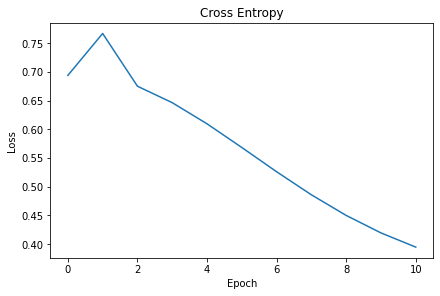

In [ ]:
plt.title("Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
print('Number of epoch', epoch, 'loss', loss.data)
predict_out = net(train_X)
_, predict_y = torch.max(predict_out, 1)
print("Train Accuracy:",accuracy_score(train_y.data, predict_y.data))
predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)
print("Test Accuracy:",accuracy_score(test_y.data, predict_y.data))
plt.plot(losses)